##  07.5 - Learning Policy on Attributes with Data Augmentation

Fully connected network with:
- Input: **184** size vector with:
    * client information: [current latitude, current longitud, destination latitude, destination longitude]
    * vehicles information: [load, queue, current latitude, current longitud, next latitude, next longitude]
    
- Output: One hot encoding vector with 30 entries representing the available vehicles


In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd
import random
import tqdm
import time 

import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch import optim

In [2]:
class Net(nn.Module):
    def __init__(self, inp, num_v):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(inp, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 500)
        self.bn2 = nn.BatchNorm1d(500)
        self.d2  = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(500, 1000)
        self.bn3 = nn.BatchNorm1d(1000)
        self.fc5 = nn.Linear(1000, 500)
        self.bn5 = nn.BatchNorm1d(500)
        self.fc6 = nn.Linear(500, 200)
        self.bn6 = nn.BatchNorm1d(200)
        self.fc7 = nn.Linear(200, num_v)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.d2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        #x = self.d5(x)
        x = self.fc7(x)
        #return F.log_softmax(x)
        return x

In [3]:
class Net2(nn.Module):
    def __init__(self, inp, num_v):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(inp, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, num_v)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        #return F.log_softmax(x)
        return x

In [4]:
def data_aug(TABLE, NUM_PERMS=20):
    data = np.load('./minmax_data/data_vector_{}.npy'.format(TABLE), allow_pickle=True).tolist()
    data_y = np.load('./minmax_data/data_vector_y_{}.npy'.format(TABLE), allow_pickle=True).tolist()
    
    all_X = []
    all_Y = []   
    
    idx = list(data.keys())
    v_sorting = list(range(30))
    
    # for each new client; avoid first since is trivial
    for c in idx[1:]:
        # select client info: current and future locations
        client_data = data[c][0]
        v_infos = np.asarray(data[c][1:])
        
        x = np.hstack((client_data, np.hstack(v_infos)))
        y = int(data_y[c])
        
        all_X.append(x)
        all_Y.append(y)
        
        for k in range(NUM_PERMS):
            new_v = v_sorting.copy()
            random.shuffle(new_v)
        
            new_x = np.hstack(v_infos[new_v])
            new_y = np.where(np.array(new_v) == y)[0][0]
            
            new_x_full = np.hstack((client_data, new_x))
            all_X.append(new_x_full)
            all_Y.append(new_y)
            
            
    return all_X, all_Y

#all_X, all_Y = data_aug(3)
    

In [5]:
def epoch_train(model, train_table, test_tables, optimizer, criterion, e, num_permutations=20):
    
    sum_loss = 0
    acc = []
    idx_failures = []

    # train data
    for k, TABLE in enumerate(train_tables):
        if num_permutations == 0:
            data = np.load('./minmax_data/data_vector_{}.npy'.format(TABLE), allow_pickle=True).tolist()
            data_y = np.load('./minmax_data/data_vector_y_{}.npy'.format(TABLE), allow_pickle=True).tolist()

            idx = list(data.keys())
        #random.shuffle(idx)
        else:
            data_X, data_Y =  data_aug(TABLE, num_permutations)
            data_X = np.asarray(data_X)
            data_Y = np.asarray(data_Y)
           

            idx = list(range(len(data_Y)))
            #random.shuffle(idx)
            
        

        for b in range(0, len(idx), mini_batch_size):

            t_idx = idx[b:b+mini_batch_size]
            
            if num_permutations == 0:
                x = np.asarray([np.hstack(data[i]) for i in t_idx])
                y = np.hstack([data_y[i] for i in t_idx])
            else:
                x = data_X[t_idx]
                y = data_Y[t_idx]
            
            train_x = torch.tensor(x).type(torch.FloatTensor)
            train_y = torch.tensor(y).type(torch.LongTensor)
            
            # set gradient to zero
            optimizer.zero_grad()
            
            # compute output
            output = model(train_x)
            batch_loss = criterion(output, train_y)
            
            batch_loss.backward()
            optimizer.step()

            sum_loss = sum_loss + batch_loss.item()
            
            _, a = torch.max(output,1)
            acc.append(float((train_y == a).sum())/len(train_y))
    
    
    test_loss = 0
    test_acc = []
    
    for k,TABLE in enumerate(test_tables):
        data = np.load('./minmax_data/data_vector_{}.npy'.format(TABLE), allow_pickle=True).tolist()
        data_y = np.load('./minmax_data/data_vector_y_{}.npy'.format(TABLE), allow_pickle=True).tolist()
        
        idx = list(data.keys())
        #random.shuffle(idx)
        
        for b in range(0, len(idx), mini_batch_size):

            t_idx = idx[b:b+mini_batch_size]
            
            x = np.asarray([np.hstack(data[i]) for i in t_idx])
            y = np.hstack([data_y[i] for i in t_idx])
            
            test_x = torch.tensor(x).type(torch.FloatTensor)
            test_y = torch.tensor(y).type(torch.LongTensor)
            
            output = model(test_x)
            batch_loss = criterion(output, test_y)
            

            test_loss += batch_loss.item()
            _, a = torch.max(output,1)
            test_acc.append(float((test_y == a).sum())/len(test_y))
            
            idx_failures += [t_idx[i] for i in np.where(test_y != a)[0]]
    print('\rEpoch {}. Train Loss: {:.3f} Accuracy: {:.3f} Test Loss: {:.3f} Accuracy: {:.3f}'.\
          format(e+1, sum_loss, np.mean(acc), test_loss,np.mean(test_acc)), end="")
    return sum_loss, np.sum(acc)/len(acc), test_loss, np.sum(test_acc)/len(test_acc), idx_failures


### General configurations

In [15]:
global MAX_V, mini_batch_size, n_epochs, lr, inp_size
MAX_V = 30
mini_batch_size = 50
n_epochs=50

tables = list(range(1,95))
random.shuffle(tables)

lr = 0.0001
inp_size = 4 + MAX_V*6

train_tables, test_tables, validation_tables = \
tables[:int(len(tables)*0.6)], tables[int(len(tables)*0.6):int(len(tables)*0.9)], tables[int(len(tables)*0.9):]

In [16]:
def evaluating_model(num_permut):
    model = Net2(inp_size, MAX_V)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    loss, acc, test_loss, test_acc, idx_f, times = [], [], [], [], [], []

    for epoch in range(n_epochs):
        current_t = time.time()
        train_l, accuracy, test_l, test_a, idx_failures = \
        epoch_train(model, train_tables, test_tables, optimizer, criterion, epoch, num_permutations=num_permut)
        
        times.append(time.time() - current_t)
        loss.append(train_l)
        test_loss.append(test_l)
        acc.append(accuracy)
        test_acc.append(test_a)
        idx_f.append(idx_failures)

    print('\nAverage time per epoch {:.3f}s +- {:.3f}'.format(np.mean(times), 2*np.std(times)))

    max_acc = np.max(test_acc)
    iter_max = np.where(test_acc ==  max_acc)

    print('Max accuracy of {:.3f} achieved at epoch {}'.format(max_acc, iter_max[0][0]))
    
    return loss, acc, test_loss, test_acc, idx_f, times


def visualize_results(loss, test_loss, acc, test_acc, idx_f):
    f, ax = plt.subplots(2, 1, figsize=(20,8))
    ax[0].plot(loss)
    ax[0].plot(test_loss)
    ax[1].plot(acc)
    ax[1].plot(test_acc)
    plt.show()
    
    max_acc = np.max(test_acc)
    iter_max = np.where(test_acc ==  max_acc) 
    iter_max = iter_max[0][0]

    fig, ax = plt.subplots(1,5, figsize=(20,4))
    k = 0
    idx = idx_f[:iter_max+1]
    for j, i in enumerate(idx[::-1]):
        if len(i) > 0:
            ax[k].hist(i, bins=50)
            ax[k].set_xlabel('Client')
            ax[k].set_ylabel('Num errors')
            ax[k].set_title('Iteration {}\nwith acc:{:.3f}'.format(-j + iter_max, test_acc[-j + iter_max]))
            k += 1
        if k == 5:
            plt.show()
            break

## Model p = 2

Epoch 50. Train Loss: 1004.800 Accuracy: 0.128 Test Loss: 181.221 Accuracy: 0.105
Average time per epoch 4.002s +- 0.115
Max accuracy of 0.105 achieved at epoch 49


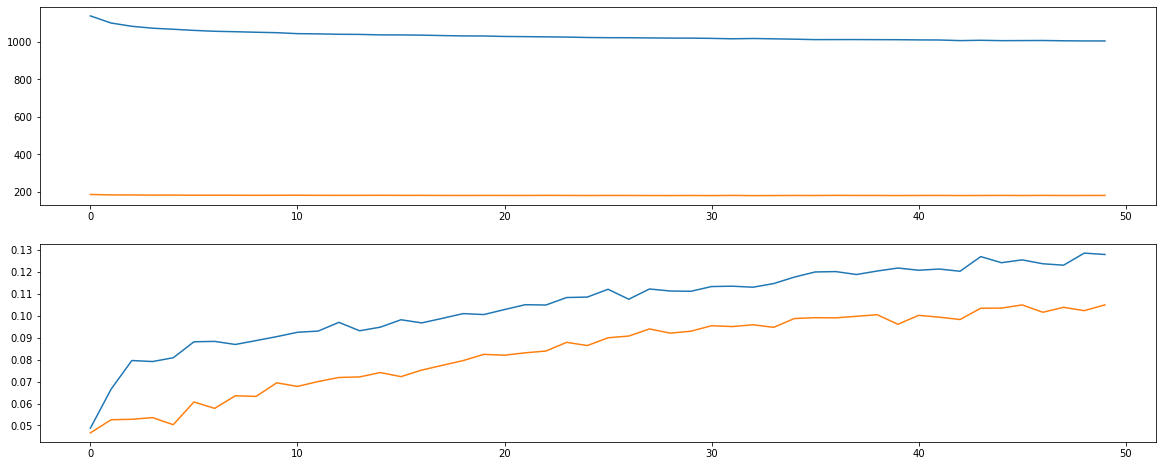

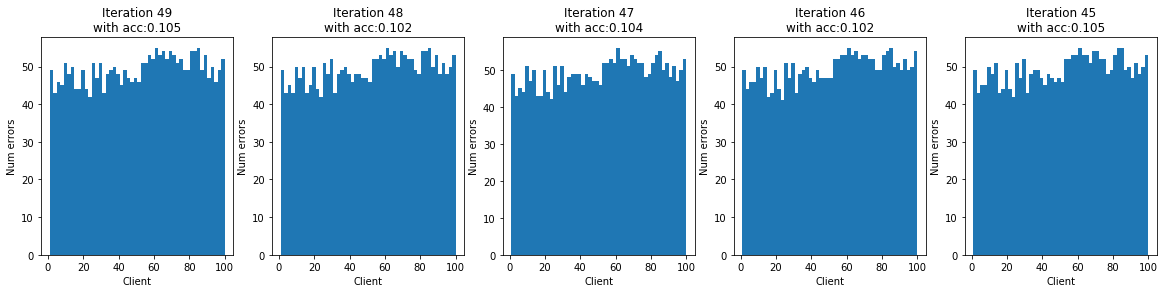

In [17]:
loss, acc, test_loss, test_acc, idx_f, times = evaluating_model(2)
visualize_results(loss, test_loss, acc, test_acc, idx_f)

## Model p = 5

Epoch 100. Train Loss: 2015.239 Accuracy: 0.119 Test Loss: 199.992 Accuracy: 0.104
Average time per epoch 7.825s +- 0.992
Max accuracy of 0.108 achieved at epoch 79


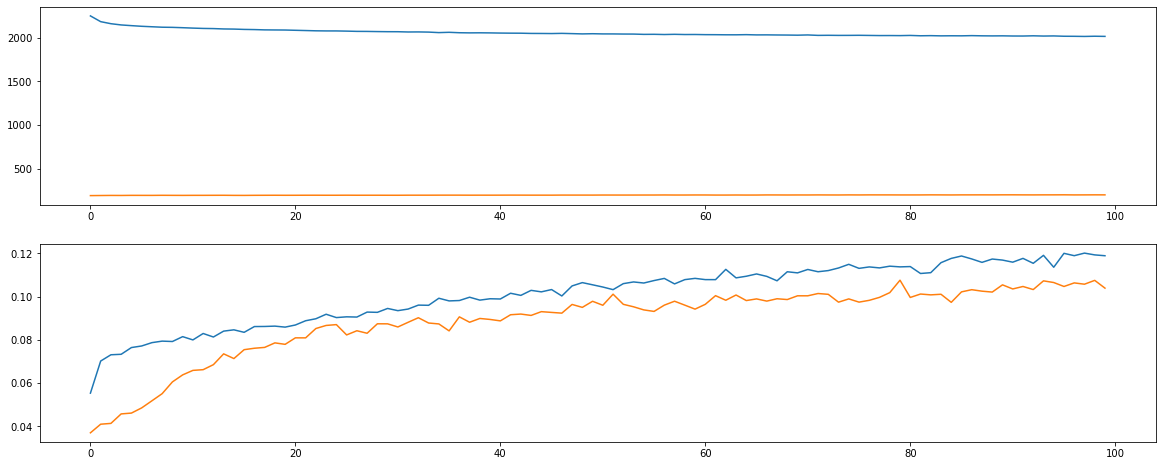

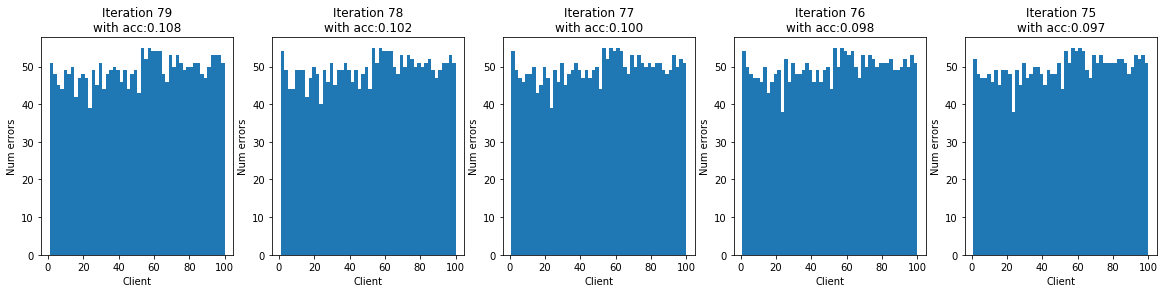

In [18]:
n_epochs = 100
loss, acc, test_loss, test_acc, idx_f, times = evaluating_model(5)
visualize_results(loss, test_loss, acc, test_acc, idx_f)

In [ ]:


# data parameters
tables = list(range(1,95))
random.shuffle(tables)

train_tables, test_tables, validation_tables = \
tables[:int(len(tables)*0.6)], tables[int(len(tables)*0.6):int(len(tables)*0.9)], tables[int(len(tables)*0.9):]

# model parameters
MAX_V = 30
mini_batch_size = 50
n_epochs=50

lr = 0.001
inp_size = 4 + MAX_V*6

model = Net2(inp_size, MAX_V)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
loss, acc, test_loss, test_acc, idx_f, times = [], [], [], [], [], []

for epoch in range(n_epochs):
    current_t = time.time()
    train_l, accuracy, test_l, test_a, idx_failures = epoch_train(model, train_tables, test_tables, optimizer, criterion, epoch, num_permutations=3)
    times.append(time.time() - current_t)
    loss.append(train_l)
    test_loss.append(test_l)
    acc.append(accuracy)
    test_acc.append(test_a)
    idx_f.append(idx_failures)
    
print('\nAverage time per epoch {:.3f}s +- {:.3f}'.format(np.mean(times), 2*np.std(times)))

max_acc = np.max(test_acc)
iter_max = np.where(test_acc ==  max_acc)

print('Max accuracy of {:.3f} achieved at epoch {}'.format(max_acc, iter_max[0][0]))

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].plot(loss)
ax[0].plot(test_loss)
ax[1].plot(acc)
ax[1].plot(test_acc)
plt.show()

In [ ]:
def test_results(test_tables, model):
    test_loss = 0
    test_acc = []
    idx_failures = []

    for k,TABLE in enumerate(test_tables):
        data = np.load('./relative_data/data_vector_{}.npy'.format(TABLE), allow_pickle=True).tolist()
        data_y = np.load('./relative_data/data_vector_y_{}.npy'.format(TABLE), allow_pickle=True).tolist()

        idx = list(data.keys())
        #random.shuffle(idx)

        for b in range(0, len(idx), mini_batch_size):

            t_idx = idx[b:b+mini_batch_size]

            x = np.asarray([np.hstack(data[i]) for i in t_idx])
            y = np.hstack([data_y[i] for i in t_idx])

            test_x = torch.tensor(x).type(torch.FloatTensor)
            test_y = torch.tensor(y).type(torch.LongTensor)

            output = model(test_x)
            batch_loss = criterion(output, test_y)


            test_loss += batch_loss.item()
            _, a = torch.max(output,1)
            test_acc.append(float((test_y == a).sum())/len(test_y))

            idx_failures += [t_idx[i] for i in np.where(test_y != a)[0]]
                
    return test_loss, test_acc, idx_failures, output, test_y, test_x

In [ ]:
test_tables

In [ ]:
a, b, c, output, y, x = test_results([test_tables[3]], model)
b

In [ ]:
for i in x:
    print(i)
    break

In [ ]:
_, a = torch.max(output,1)
print(a)
print(y)
print(x[0][:4])
print(x[0][4 + 14*6:14*6+10])
print(x[0][4 + 12*6:12*6+10])

In [ ]:
float(kk)/len(y)

In [ ]:
data = np.load('./relative_data/data_vector_{}.npy'.format(TABLE), allow_pickle=True).tolist()
data_y = np.load('./relative_data/data_vector_y_{}.npy'.format(TABLE), allow_pickle=True).tolist()



In [ ]:
fig, ax = plt.subplots(1,5, figsize=(15,4))
k = 0
for i in idx_f[::-1]:
    if len(i) > 0:
        ax[k].hist(i, bins=50)
        k += 1
    if k == 5:
        plt.show()
        break